In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.qubits.transmon_cross_fl import TransmonCrossFL
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder

In [4]:
from qiskit_metal.analyses.quantization import EPRanalysis
design.delete_all_components()

In [35]:
design.overwrite_enabled = True

xmon_options_1 = dict(chip='main', make_fl=False, cross_gap = '30um', cross_width = '30um', cross_length= '240um', 
    connection_pads=dict(
        #dl1 = dict( connector_location = '0', connector_type = '1'),
        b1 = dict(connector_location = '180', connector_type = '0', claw_length = '175um', claw_width = '7um', claw_gap= '6um', ground_spacing='4um'),
        #r1 = dict(connector_location = '90', connector_type = '0', claw_length = '210um', claw_width = '15um', claw_gap= '6um'), 
    
    ),
)

xmon_options_2 = dict(chip='main', make_fl=False, cross_gap = '30um', cross_width = '25um', cross_length= '220um', 
    connection_pads=dict(
        #dl2 = dict( connector_location = '180', connector_type = '1'),
        b2 = dict(connector_location = '-180', connector_type = '0', claw_length = '180um', claw_width = '7um', claw_gap= '6um', ground_spacing='4um'),
        #r2 = dict(connector_location = '90', connector_type = '0', claw_length = '210um', claw_width = '15um', claw_gap= '6um'), 
    
    ),
)

q1 = TransmonCrossFL(design, 'Q1', options=xmon_options_1)
q2 = TransmonCrossFL(design, 'Q2', options=xmon_options_2)

q_pos_y = '-1.3 mm'

q1.options.pos_x = '-1.3mm'
q1.options.pos_y = q_pos_y

q2.options.pos_x = '1.3mm'
q2.options.pos_y = q_pos_y

coupler_options = Dict(chip='main',pin_inputs=Dict(
                                start_pin=dict(component='Q1', pin='b1'),
                        end_pin=dict(
                                component='Q2', pin='b2')),
                        fillet='80um',
                        total_length = '6.5mm',
                        lead = dict(start_straight = '390um', end_straight = '150um',
                                   ), trace_width = '7um')

bus = RouteMeander(design, 'bus1', options= coupler_options)

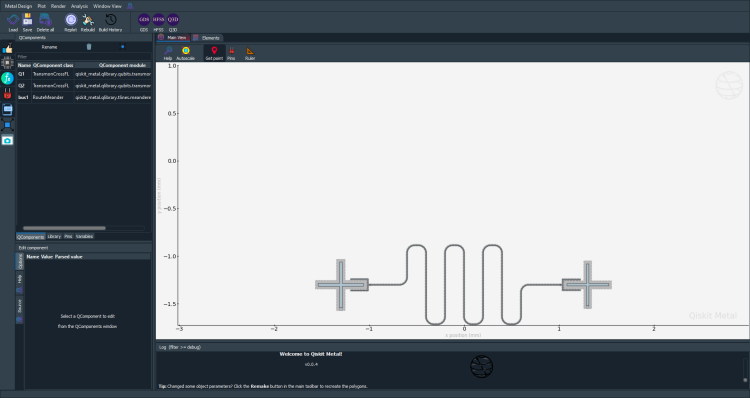

In [36]:
gui.rebuild()
gui.autoscale()
gui.screenshot()

# Simulating the Bus frequency

In [ ]:
eig_bus = EPRanalysis(design, "hfss")

eig_bus.sim.setup.max_passes = 20
eig_bus.sim.setup.max_delta_f = 0.05
eig_bus.sim.setup.n_modes = 2

eig_bus.sim.run(name="bus1",
               components=['bus1'],
               open_terminations=[('bus1', 'start'), ('bus1', 'end')])


In [ ]:
%matplotlib inline
eig_bus.sim.plot_convergences()
eig_bus.sim.convergence_f
eig_bus.sim.plot_fields('main')
eig_bus.sim.save_screenshot()

In [ ]:
eig_bus.get_frequencies()

In [ ]:
eig_bus.sim.setup

# Simulating Q1+Bus+Q2 to extract the coupling strengths

In [42]:
#Simulate Q1 + bus coupling strength

eig_q12bus = EPRanalysis(design, "hfss")
hfss1 = eig_q12bus.sim.renderer
eig_q12bus.sim.setup.max_passes = 12
eig_q12bus.sim.setup.max_delta_f = 0.05
eig_q12bus.sim.setup.n_modes = 3
eig_q12bus.sim.setup.vars = Dict(Lj1='10.58 nH', Cj1='0 fF', Lj2='7.58 nH', Cj2='0 fF')


In [43]:
eig_q12bus.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_q12bus.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_q12bus.sim.renderer.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.5,
 'y_buffer_width_mm': 0.5,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [44]:
eig_q12bus.sim.run(name="Q1+Bus+Q2",
                 components=['Q1', 'bus1', 'Q2'],
                 open_terminations=[])

INFO 12:42PM [connect_design]: 	Opened active design
	Design:    Q1+Bus+Q2_hfss [Solution type: Eigenmode]
INFO 12:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:42PM [analyze]: Analyzing setup Setup
12:46PM 50s INFO [get_f_convergence]: Saved convergences to C:\Users\Crow104\Dropbox\nonMark_exp\2D_Designs\hfss_eig_f_convergence.csv


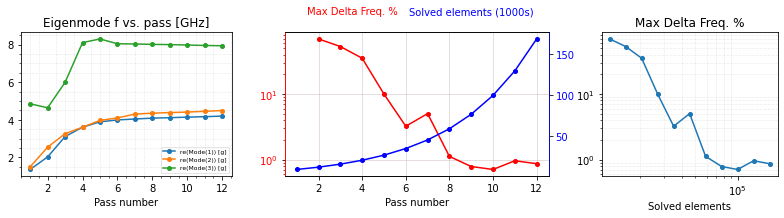

In [45]:
%matplotlib inline
eig_q12bus.sim.plot_convergences()

INFO 12:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


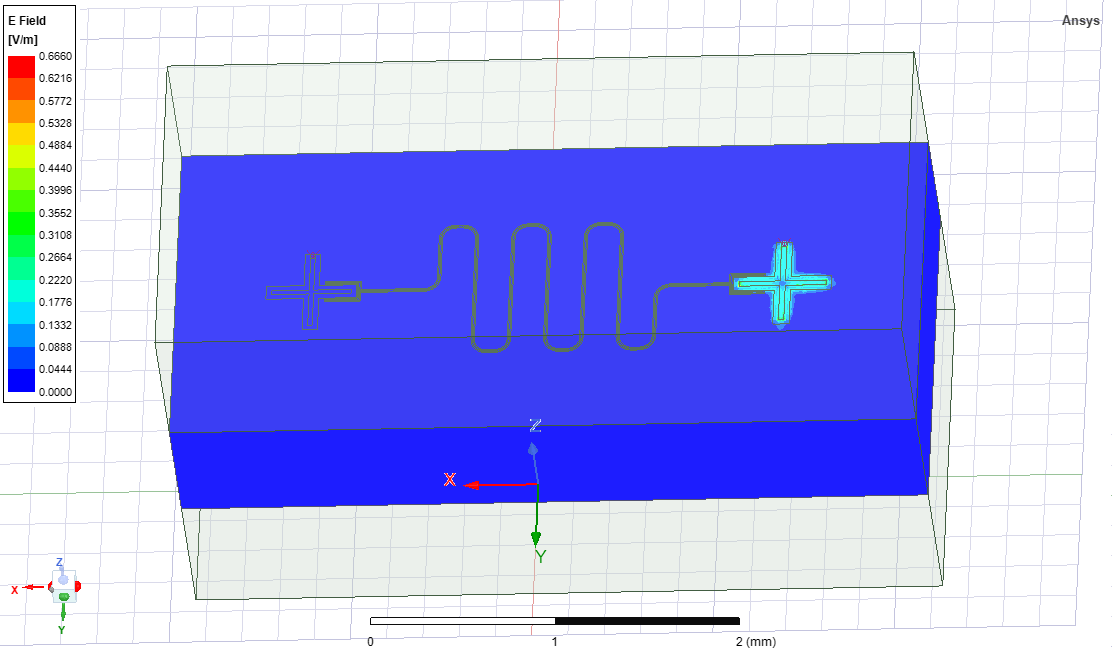

INFO 12:48PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:48PM [load_ansys_project]: 	Opened Ansys App
INFO 12:48PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 12:48PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Crow104/Documents/Ansoft/
	Project:   Project56
INFO 12:48PM [connect_design]: 	Opened active design
	Design:    Q1+Bus+Q2_hfss [Solution type: Eigenmode]
INFO 12:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:48PM [connect]: 	Connected to project "Project56" and design "Q1+Bus+Q2_hfss" 😀 



Design "Q1+Bus+Q2_hfss" info:
	# eigenmodes    3
	# variations    1

ℰ_elec_all       = 4.03112750874492e-24
ℰ_elec_substrate = 3.7053671436888e-24
EPR of substrate = 91.9%

ℰ_mag    = 5.3073849676243e-26

This analysis object run with the following kwargs:
{'name': 'Q1+Bus+Q2', 'components': ['Q1', 'bus1', 'Q2'], 'open_terminations': [], 'port_list': None, 'jj_to_port': None, 'ignored_jjs': None, 'box_plus_buffer': True}

Design "Q1+Bus+Q2_hfss" info:
	# eigenmodes    3
	# variations    1
Design "Q1+Bus+Q2_hfss" info:
	# eigenmodes    3
	# variations    1

        energy_elec_all       = 4.03112750874492e-24
        energy_elec_substrate = 3.7053671436888e-24
        EPR of substrate = 91.9%

        energy_mag    = 5.3073849676243e-26
        energy_mag % of energy_elec_all  = 1.3%
        

Variation 0  [1/1]

  Mode 0 at 4.20 GHz   [1/3]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.7%  2.016e-24 2.654e-26

    Calculating junction

WARNING 12:49PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 12:49PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 25.6% is > 15%.                     
Is the simulation converged? Proceed with caution



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project56\Q1+Bus+Q2_hfss\2021-12-15 12-48-41.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0



INFO 12:49PM [__del__]: Disconnected from Ansys HFSS


Starting the diagonalization


INFO 12:49PM [__del__]: Disconnected from Ansys HFSS
INFO 12:49PM [__del__]: Disconnected from Ansys HFSS


Finished the diagonalization


ERROR 12:49PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 25.6% is > 15%.                     
Is the simulation converged? Proceed with caution


Pm_norm=
modes
0    1.073695
1    0.771944
2    0.837079
dtype: float64

Pm_norm idx =
     jj1    jj2
0   True  False
1  False   True
2  False  False
*** P (participation matrix, not normlz.)
        jj1       jj2
0  0.918838  0.000002
1  0.000001  1.281134
2  0.000110  0.000225

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1      1
1      1      1
2      1      1
*** P (participation matrix, normalized.)
      0.99  1.5e-06
   1.2e-06     0.99
   0.00011  0.00022

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       139 0.000685   0.0583
  0.000685      114   0.0918
    0.0583   0.0918 2.45e-05

*** Chi matrix ND (MHz) 
       149    0.002   0.0567
     0.002      121   0.0881
    0.0567   0.0881 2.21e-05

*** Frequencies O1 PT (MHz)
0    4060.030745
1    4378.357783
2    7935.352358
dtype: float64

*** Frequencies ND (MHz)
0    4055.117890
1    4375.285408
2    7935.352502
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1,

KeyError: '_Lj'

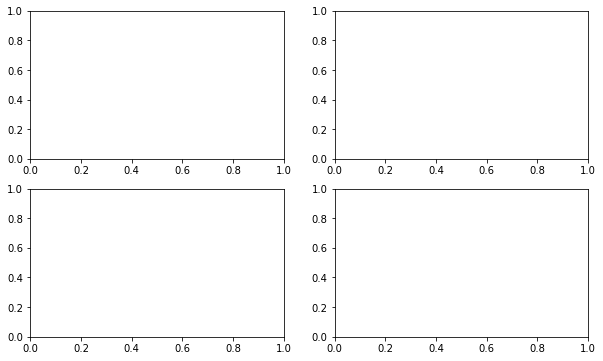

In [47]:
eig_q12bus.sim.convergence_f

eig_q12bus.sim.plot_fields('main', eigenmode=1)
eig_q12bus.sim.save_screenshot()

hfss1.start()

pinfo1 = hfss1.pinfo

#pinfo1.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj',
#                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
#pinfo1.validate_junction_info() # Check that valid names of variables and objects have been supplied
#pinfo1.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify

import pyEPR as epr

eprd1 = epr.DistributedAnalysis(pinfo1)

ℰ_elec = eprd1.calc_energy_electric()
ℰ_elec_substrate = eprd1.calc_energy_electric(None, 'main')
ℰ_mag = eprd1.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag    = {ℰ_mag}
""")

pinfo1.junctions

eig_q12bus.sim.clear_fields()

eig_q12bus.setup

eig_q12bus.sim.print_run_args()

del eig_q12bus.setup.junctions['jj']
eig_q12bus.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_', Lj_variable='Lj1', Cj_variable='Cj1')
eig_q12bus.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_', Lj_variable='Lj2', Cj_variable='Cj2')

eig_q12bus.setup

eig_q12bus.run_epr()

In [ ]:
eig_q12bus.sim.setup

INFO 12:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


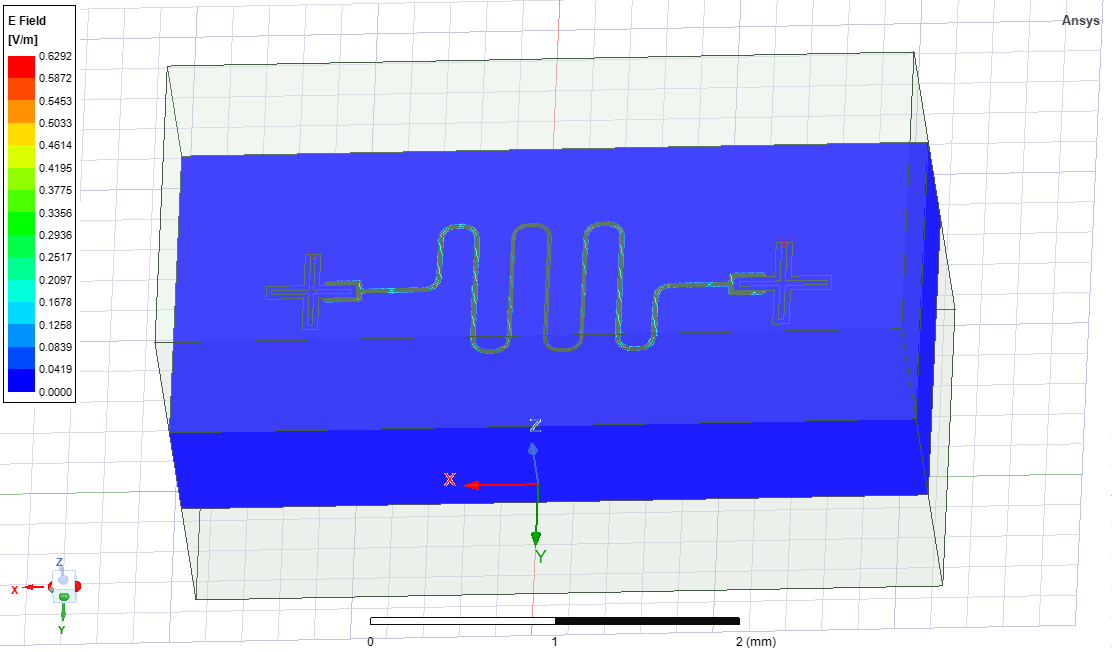

WindowsPath('C:/Users/Crow104/Dropbox/nonMark_exp/2D_Designs/ansys.png')

In [50]:
eig_q12bus.sim.plot_fields('main', eigenmode=3)
eig_q12bus.sim.save_screenshot()